In [2]:
#Importo las librerías necesarias
from sklearn.preprocessing import MinMaxScaler

import numpy as np
#Semilla para asegurar valores aleatorios
np.random.seed(10)

import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers

Cargo los datos, luego los separo por entradas y los normalizo

In [3]:
data = pd.read_csv("D:\\Programas\\OneDrive - Estudiantes ITCR\\TEC\\Semestre 9\\IA\\Tareas\\Tarea1_IA\\ParteA\\synchronous machine.csv", sep=';')

X=data[["Iy", "PF", "e", "dIf"]]
y=data[["If"]]
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaler1.fit(X)
X_data = scaler1.transform(X)

scaler2 = MinMaxScaler(feature_range=(0, 1))
scaler2.fit(y)
y_data = scaler2.transform(y)

Divido los datos en datos de entrenamiento y datos de testeo
60% entrenamiento, 40% para test

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

Las siguientes funciones sirven para imprimir la curva de aprendizaje de la red

In [5]:
#Las siguientes funciones sirven para imprimir la curva de aprendizaje de la red

class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,0.7])
  plt.legend()
  plt.show()

Se definen los parámetros de la red neuronal

In [6]:
model = keras.Sequential([
  layers.Dense(4, activation='sigmoid', input_shape=[4]), #Número de entradas
  layers.Dense(4, activation='sigmoid'),

  layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.06) #Define el optimizador

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
               metrics=['accuracy', "mae", "mse"])


Entreno el modelo e imprimo la curva de aprendizaje


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

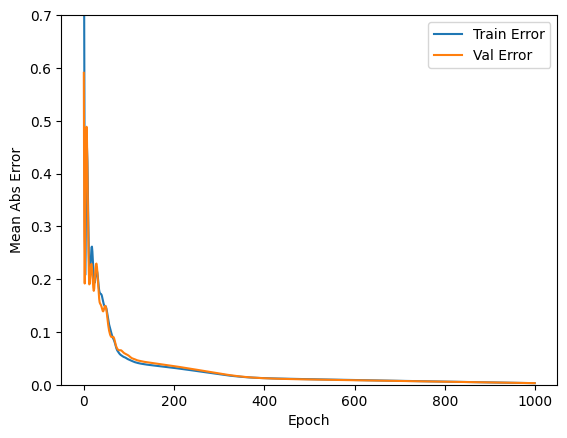

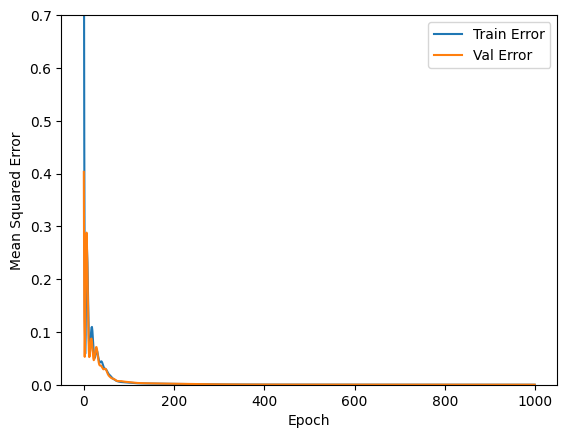

In [7]:
history = model.fit(X_train,y_train,
                    validation_data=(X_test, y_test),
                    epochs = 1000,
                    batch_size=512, 
                    verbose = 0, 
                    callbacks = [PrintDot()])

plot_history(history)

In [8]:
# Se serializa el modelo en formato JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# Se serializan los pesos a formato HDF5
model.save_weights("model.h5")
print("Modelo Guardado!")


Modelo Guardado!


A partir de este punto está el código de implementación de la red

Alimento el modelo ya entrenado con las 81 combinaciones de entradas para el punto 3 A

In [9]:
#Cargo la combinación de datos
resultado = pd.read_csv("datos_combinaciones.csv")

#Normalizo los datos cargados
scaler3 = MinMaxScaler(feature_range=(0, 1))
scaler3.fit(resultado)
normal = scaler3.transform(resultado)

#Predigo utilizando el modelo
puntoA = model.predict(normal)

#Desnormalizo las salidas
puntoA_final = scaler2.inverse_transform(puntoA)
puntoA_final = pd.DataFrame(puntoA_final, columns= ["If_predicted"])

#Uno las columnas de datos de entrada junto con la columna de valores predichos
salida = pd.concat([resultado, puntoA_final], axis=1) 

#Imprimo los valores de corrientes predichas y guardo en un archivo .csv la tabla generada
salida.to_csv("Datos_predichos.csv")
salida.head()

3/3 [==============================] - 0s 2ms/step


,Iy,PF,e,dIf,If_predicted
0,3.0,0.64,0.01,0.031,1.317968
1,3.0,0.64,0.01,0.402,1.788157
2,3.0,0.64,0.01,0.799,2.049269
3,3.0,0.64,0.14,0.031,1.268365
4,3.0,0.64,0.14,0.402,1.700181


Punto 3 B: utilización del modelo para realizar una clasificación tipo Ceteris Paribus en un conjunto de datos generados manualmente al variar en 5%, 10%, 20%, 40% y 60% cada uno de los datos de las columnas individualmente.

In [13]:
#Normalizo los datos cargados
cp = pd.read_csv("DatosParaCeterisParibus.csv")
scaler4 = MinMaxScaler(feature_range=(0, 1))
scaler4.fit(cp)
cp_normal = scaler4.transform(cp)

#Predigo los nuevos datos
ceteris = model.predict(cp_normal)

#Desnormalizo las salidas
out = scaler2.inverse_transform(ceteris)

ceteris = pd.DataFrame(out, columns= ["If_predicted"])
ceteris_paribus = pd.concat([cp, ceteris], axis=1)
ceteris_paribus.head()

1/1 [==============================] - 0s 44ms/step


,ly,PF,e,dlf,If_predicted
0,3.00,0.64,0.01,0.031,1.687554
1,0.15,0.64,0.01,0.031,1.679379
2,0.30,0.64,0.01,0.031,1.679605
3,0.60,0.64,0.01,0.031,1.680119
4,1.20,0.64,0.01,0.031,1.681407


Por último, calculo el porcentaje de variación respecto al primer dato que se introdujo, el cual es el dato original sin ningún tipo de variación.
Este porcentaje se calculará como si fuera un porcentaje de error, de forma que el primer dato tendrá un porcentaje igual a cero. 

In [43]:
if_predicted = ceteris_paribus[['If_predicted']]


var = ((1.687554 - if_predicted)/1.687554) * 100
var = var.rename(columns={'If_predicted': '% error'})

variacion = pd.concat([ceteris_paribus, var], axis=1)



,ly,PF,e,dlf,If_predicted,% error
0,3.00,0.640,0.0100,0.03100,1.687554,0.000021
1,0.15,0.640,0.0100,0.03100,1.679379,0.484451
2,0.30,0.640,0.0100,0.03100,1.679605,0.471058
3,0.60,0.640,0.0100,0.03100,1.680119,0.440605
4,1.20,0.640,0.0100,0.03100,1.681407,0.364250
5,1.80,0.640,0.0100,0.03100,1.683064,0.266045
6,3.00,0.032,0.0100,0.03100,1.931747,-14.470209
7,3.00,0.064,0.0100,0.03100,1.920264,-13.789754
8,3.00,0.128,0.0100,0.03100,1.896239,-12.366139
9,3.00,0.256,0.0100,0.03100,1.844830,-9.319757
